In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).



📄 5 Contoh Data:
                                           filepaths      labels
0  /content/gdrive/MyDrive/kain_dataset/kain_hija...  kain_hijau
1  /content/gdrive/MyDrive/kain_dataset/kain_hija...  kain_hijau
2  /content/gdrive/MyDrive/kain_dataset/kain_hija...  kain_hijau
3  /content/gdrive/MyDrive/kain_dataset/kain_hija...  kain_hijau
4  /content/gdrive/MyDrive/kain_dataset/kain_hija...  kain_hijau

📊 Jumlah gambar per label:
labels
kain_hijau    750
kain_merah    750
Name: count, dtype: int64


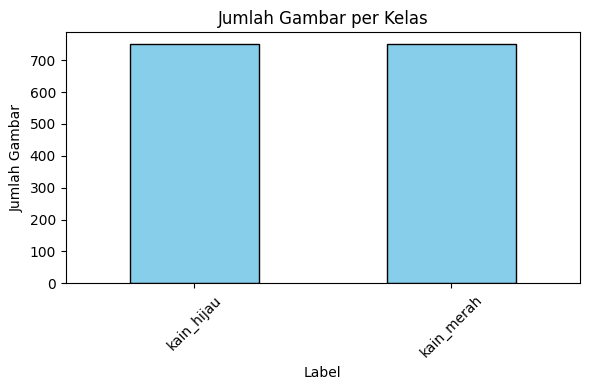

In [ ]:
sdir = '/content/gdrive/MyDrive/kain_dataset/'
filepaths = []
labels = []

for label in os.listdir(sdir):
    classpath = os.path.join(sdir, label)
    if os.path.isdir(classpath):
        for f in os.listdir(classpath):
            if f.lower().endswith(('jpg', 'jpeg', 'png')):
                filepaths.append(os.path.join(classpath, f))
                labels.append(label)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
print("\n📄 5 Contoh Data:")
print(df.head())
print("\n📊 Jumlah gambar per label:")
print(df['labels'].value_counts())

# ✅ 3. Visualisasi Jumlah Gambar
plt.figure(figsize=(6,4))
df['labels'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Jumlah Gambar per Kelas')
plt.xlabel('Label')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

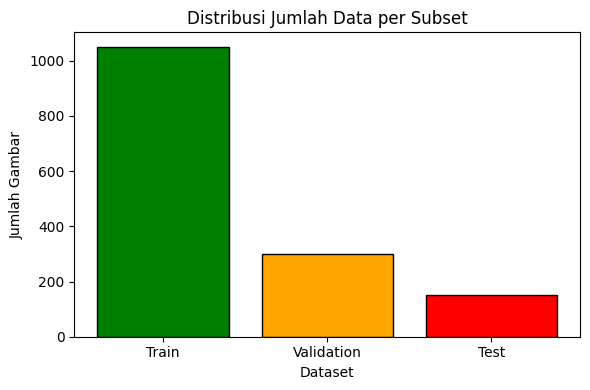

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['labels'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=1/3, stratify=temp_df['labels'], random_state=42)

# ✅ Tambah Visualisasi Split
split_counts = {
    'Train': len(train_df),
    'Validation': len(val_df),
    'Test': len(test_df)
}
plt.figure(figsize=(6, 4))
plt.bar(split_counts.keys(), split_counts.values(), color=['green', 'orange', 'red'], edgecolor='black')
plt.title("Distribusi Jumlah Data per Subset")
plt.ylabel("Jumlah Gambar")
plt.xlabel("Dataset")
plt.tight_layout()
plt.show()


Found 1050 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.
Found 14 validated image filenames belonging to 2 classes.


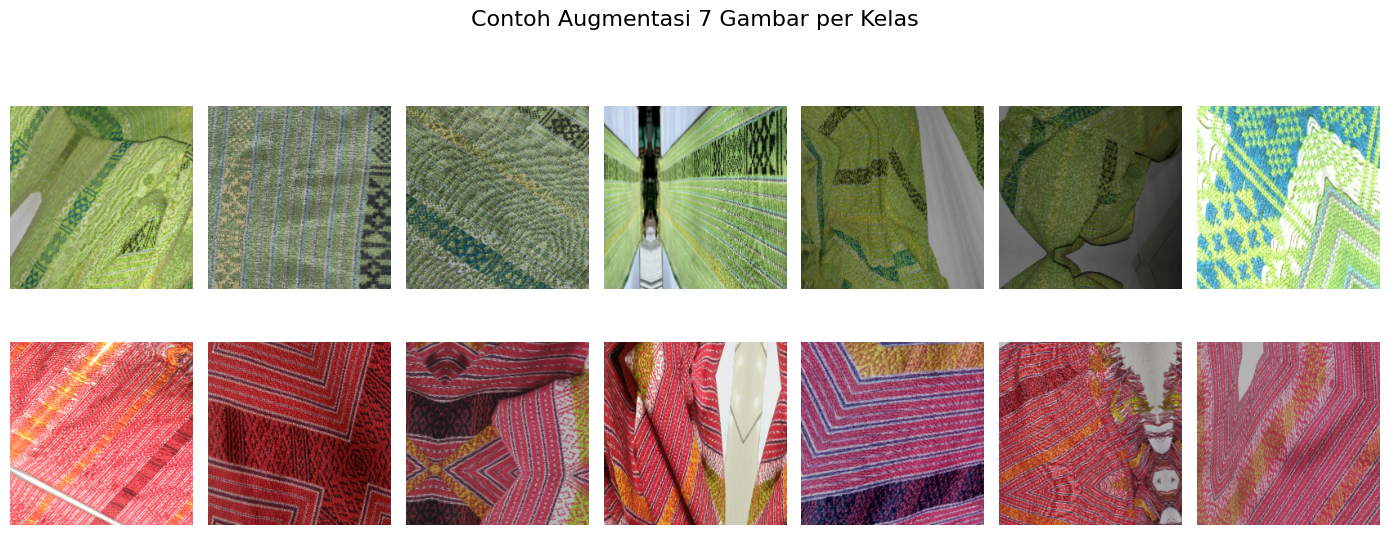

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True,
    vertical_flip=True,
    channel_shift_range=40.0,
    fill_mode='reflect'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                               target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                                               class_mode='categorical')
val_gen = val_test_datagen.flow_from_dataframe(val_df, x_col='filepaths', y_col='labels',
                                               target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                                               class_mode='categorical')
test_gen = val_test_datagen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                                target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                                                class_mode='categorical', shuffle=False)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['labels']),
    y=train_df['labels']
)
class_weights_dict = dict(enumerate(class_weights))

sample_aug_df = pd.concat([
    train_df[train_df['labels'] == 'kain_hijau'].sample(7, random_state=42),
    train_df[train_df['labels'] == 'kain_merah'].sample(7, random_state=42)
])
aug_gen = train_datagen.flow_from_dataframe(sample_aug_df, x_col='filepaths', y_col='labels',
                                            target_size=IMAGE_SIZE, batch_size=14,
                                            class_mode='categorical', shuffle=False)
augmented_imgs, _ = next(aug_gen)
plt.figure(figsize=(14, 6))
for i in range(14):
    plt.subplot(2, 7, i + 1)
    plt.imshow(augmented_imgs[i])
    plt.axis('off')
plt.suptitle("Contoh Augmentasi 7 Gambar per Kelas", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
mobilenet = MobileNetV2(include_top=False, input_shape=(224,224,3), weights='imagenet')
mobilenet.trainable = True
for layer in mobilenet.layers[:-30]:
    layer.trainable = False

model = Sequential([
    mobilenet,
    GlobalAveragePooling2D(),
    Dropout(0.7),
    Dense(32, activation='relu'),
    Dropout(0.6),
    Dense(len(train_gen.class_indices), activation='softmax')
])

loss_fn = CategoricalCrossentropy(label_smoothing=0.05)
model.compile(optimizer=Nadam(learning_rate=0.00001),
              loss=loss_fn,
              metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        40,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,299,042 (8.77 MB)

 Trainable params: 1,567,458 (5.98 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
checkpoint_path = '/content/gdrive/MyDrive/model_kain_best_valacc.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[reduce_lr, checkpoint],
    class_weight=class_weights_dict
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4940 - loss: 1.3592
Epoch 1: val_accuracy improved from -inf to 0.52667, saving model to /content/gdrive/MyDrive/model_kain_best_valacc.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 312s 9s/step - accuracy: 0.4945 - loss: 1.3571 - val_accuracy: 0.5267 - val_loss: 0.8368 - learning_rate: 1.0000e-05
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5050 - loss: 1.2300
Epoch 2: val_accuracy improved from 0.52667 to 0.57333, saving model to /content/gdrive/MyDrive/model_kain_best_valacc.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 257s 8s/step - accuracy: 0.5055 - loss: 1.2297 - val_accuracy: 0.5733 - val_loss: 0.7653 - learning_rate: 1.0000e-05
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5598 - loss: 1.1028
Epoch 3: val_accuracy improved from 0.57333 to 0.62333, saving model to /content/gdrive/MyDrive/model_kain_best_valacc.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 283s 9s/step - accuracy: 0.5605 - loss: 1.1011 - val_accuracy: 0.6233 - val_loss: 0.6977 - learning_rate: 1.0000e-05
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6189 - loss: 0.9331
Epoch 4: val_accuracy improved from 0.62333 to 0.64667, saving model to /content/gdrive/MyDrive/model_kain_best_valacc.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 320s 9s/step - accuracy: 0.6189 - loss: 0.9324 - val_accuracy: 0.6467 - val_loss: 0.6440 - learning_rate: 1.0000e-05
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6839 - loss: 0.7821
Epoch 5: val_accuracy improved from 0.64667 to 0.66667, saving model to /content/gdrive/MyDrive/model_kain_best_valacc.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 250s 8s/step - accuracy: 0.6832 - loss: 0.7827 - val_accuracy: 0.6667 - val_loss: 0.6019 - learning_rate: 1.0000e-05
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6749 - loss: 0.7723
Epoch 6: val_accuracy improved from 0.66667 to 0.70333, saving model to /content/gdrive/MyDrive/model_kain_best_valacc.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 250s 8s/step - accuracy: 0.6750 - loss: 0.7718 - val_accuracy: 0.7033 - val_loss: 0.5565 - learning_rate: 1.0000e-05
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7039 - loss: 0.6751
Epoch 7: val_accuracy improved from 0.70333 to 0.71333, saving model to /content/gdrive/MyDrive/model_kain_best_valacc.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 255s 8s/step - accuracy: 0.7034 - loss: 0.6761 - val_accuracy: 0.7133 - val_loss: 0.5223 - learning_rate: 1.0000e-05
Epoch 8/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7196 - loss: 0.6418
Epoch 8: val_accuracy improved from 0.71333 to 0.73333, saving model to /content/gdrive/MyDrive/model_kain_best_valacc.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 248s 8s/step - accuracy: 0.7202 - loss: 0.6412 - val_accuracy: 0.7333 - val_loss: 0.4895 - learning_rate: 1.0000e-05
Epoch 9/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7564 - loss: 0.5914
Epoch 9: val_accuracy improved from 0.73333 to 0.75667, saving model to /content/gdrive/MyDrive/model_kain_best_valacc.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 249s 8s/step - accuracy: 0.7564 - loss: 0.5916 - val_accuracy: 0.7567 - val_loss: 0.4685 - learning_rate: 1.0000e-05
Epoch 10/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7774 - loss: 0.5682
Epoch 10: val_accuracy improved from 0.75667 to 0.77667, saving model to /content/gdrive/MyDrive/model_kain_best_valacc.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 283s 9s/step - accuracy: 0.7771 - loss: 0.5687 - val_accuracy: 0.7767 - val_loss: 0.4458 - learning_rate: 1.0000e-05
Epoch 11/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8167 - loss: 0.4906
Epoch 11: val_accuracy improved from 0.77667 to 0.78667, saving model to /content/gdrive/MyDrive/model_kain_best_valacc.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 248s 8s/step - accuracy: 0.8159 - loss: 0.4915 - val_accuracy: 0.7867 - val_loss: 0.4221 - learning_rate: 1.0000e-05
Epoch 12/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7892 - loss: 0.5231
Epoch 12: val_accuracy improved from 0.78667 to 0.81000, saving model to /content/gdrive/MyDrive/model_kain_best_valacc.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 294s 9s/step - accuracy: 0.7896 - loss: 0.5226 - val_accuracy: 0.8100 - val_loss: 0.4006 - learning_rate: 1.0000e-05
Epoch 13/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8140 - loss: 0.4631
Epoch 13: val_accuracy improved from 0.81000 to 0.82333, saving model to /content/gdrive/MyDrive/model_kain_best_valacc.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 248s 8s/step - accuracy: 0.8141 - loss: 0.4628 - val_accuracy: 0.8233 - val_loss: 0.3848 - learning_rate: 1.0000e-05
Epoch 14/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8432 - loss: 0.4204
Epoch 14: val_accuracy improved from 0.82333 to 0.83667, saving model to /content/gdrive/MyDrive/model_kain_best_valacc.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 261s 8s/step - accuracy: 0.8427 - loss: 0.4213 - val_accuracy: 0.8367 - val_loss: 0.3686 - learning_rate: 1.0000e-05
Epoch 15/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8494 - loss: 0.4194
Epoch 15: val_accuracy improved from 0.83667 to 0.85667, saving model to /content/gdrive/MyDrive/model_kain_best_valacc.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 248s 8s/step - accuracy: 0.8491 - loss: 0.4194 - val_accuracy: 0.8567 - val_loss: 0.3581 - learning_rate: 1.0000e-05
Epoch 16/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8486 - loss: 0.3998
Epoch 16: val_accuracy improved from 0.85667 to 0.86000, saving model to /content/gdrive/MyDrive/model_kain_best_valacc.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 280s 8s/step - accuracy: 0.8484 - loss: 0.4000 - val_accuracy: 0.8600 - val_loss: 0.3461 - learning_rate: 1.0000e-05
Epoch 17/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8311 - loss: 0.4293
Epoch 17: val_accuracy improved from 0.86000 to 0.87333, saving model to /content/gdrive/MyDrive/model_kain_best_valacc.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 250s 8s/step - accuracy: 0.8317 - loss: 0.4285 - val_accuracy: 0.8733 - val_loss: 0.3340 - learning_rate: 1.0000e-05
Epoch 18/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8619 - loss: 0.3990
Epoch 18: val_accuracy improved from 0.87333 to 0.89000, saving model to /content/gdrive/MyDrive/model_kain_best_valacc.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 259s 7s/step - accuracy: 0.8620 - loss: 0.3986 - val_accuracy: 0.8900 - val_loss: 0.3199 - learning_rate: 1.0000e-05
Epoch 19/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8976 - loss: 0.3459
Epoch 19: val_accuracy improved from 0.89000 to 0.92000, saving model to /content/gdrive/MyDrive/model_kain_best_valacc.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 240s 7s/step - accuracy: 0.8975 - loss: 0.3460 - val_accuracy: 0.9200 - val_loss: 0.3094 - learning_rate: 1.0000e-05
Epoch 20/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8802 - loss: 0.3610
Epoch 20: val_accuracy improved from 0.92000 to 0.92667, saving model to /content/gdrive/MyDrive/model_kain_best_valacc.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 268s 7s/step - accuracy: 0.8800 - loss: 0.3613 - val_accuracy: 0.9267 - val_loss: 0.2978 - learning_rate: 1.0000e-05
Epoch 21/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8647 - loss: 0.3781
Epoch 21: val_accuracy improved from 0.92667 to 0.93333, saving model to /content/gdrive/MyDrive/model_kain_best_valacc.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 246s 7s/step - accuracy: 0.8649 - loss: 0.3779 - val_accuracy: 0.9333 - val_loss: 0.2879 - learning_rate: 1.0000e-05
Epoch 22/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8937 - loss: 0.3262
Epoch 22: val_accuracy did not improve from 0.93333
33/33 ━━━━━━━━━━━━━━━━━━━━ 295s 8s/step - accuracy: 0.8934 - loss: 0.3265 - val_accuracy: 0.9333 - val_loss: 0.2805 - learning_rate: 1.0000e-05
Epoch 23/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8863 - loss: 0.3399
Epoch 23: val_accuracy did not improve from 0.93333
33/33 ━━━━━━━━━━━━━━━━━━━━ 244s 7s/step - accuracy: 0.8858 - loss: 0.3405 - val_accuracy: 0.9333 - val_loss: 0.2754 - learning_rate: 1.0000e-05
Epoch 24/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8970 - loss: 0.3388
Epoch 24: val_accuracy improved from 0.93333 to 0.93667, saving model to /content/gdrive/MyDrive/model_kain_best_valacc.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 248s 8s/step - accuracy: 0.8971 - loss: 0.3384 - val_accuracy: 0.9367 - val_loss: 0.2692 - learning_rate: 1.0000e-05
Epoch 25/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9046 - loss: 0.3173
Epoch 25: val_accuracy improved from 0.93667 to 0.94000, saving model to /content/gdrive/MyDrive/model_kain_best_valacc.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 260s 7s/step - accuracy: 0.9042 - loss: 0.3177 - val_accuracy: 0.9400 - val_loss: 0.2632 - learning_rate: 1.0000e-05


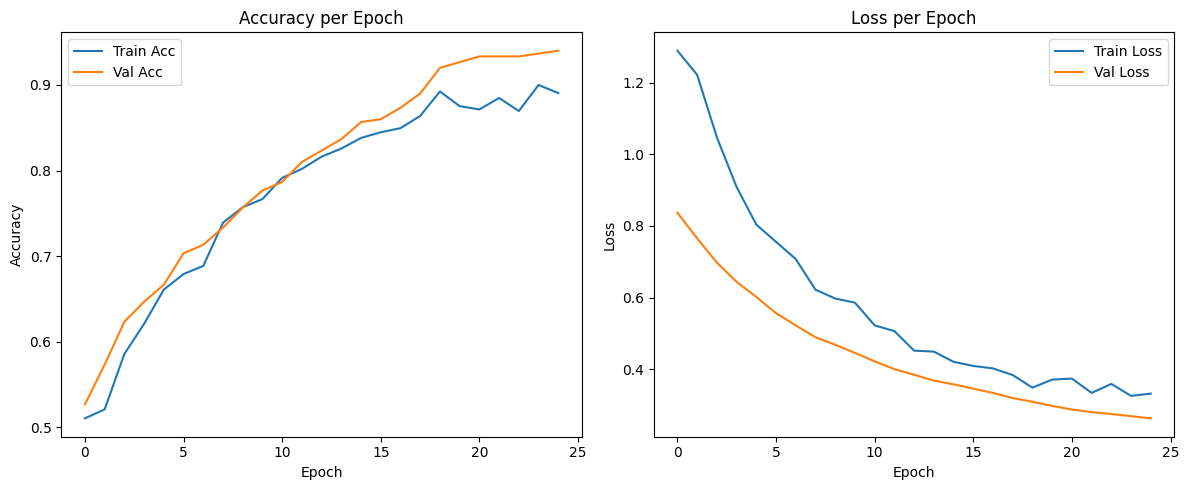

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

predictions = model.predict(test_gen)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')

plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
checkpoint_path = '/content/gdrive/MyDrive/model_kain_best_valacc.h5'

best_model = load_model(checkpoint_path)

best_model.save('/content/gdrive/MyDrive/model_kain_final_best.h5')

best_model.export('/content/gdrive/MyDrive/model_kain_final_best_savedmodel')


Saved artifact at '/content/gdrive/MyDrive/model_kain_final_best_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  137830332895056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137830332895824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137830332896208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137830332896016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137830332894288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137830332897360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137830332897744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137830332898128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137830332897936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137830332895248: TensorSpec(shape=(), dtype

In [ ]:
label_to_palette = {
    'kain_hijau': [(170,190,149), (171,191,150), (164,191,133), (160,185,141), (138,171,116), (120,160,110), (110,150,100)],
    'kain_merah': [(166,78,88), (189,88,108), (174,75,74), (142,62,60), (195,105,110), (160,60,65), (140,40,40)]
}

def predict_and_show_palette(model, image_path, label_to_palette):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    pred = model.predict(img_array)
    predicted_class = np.argmax(pred)
    confidence = np.max(pred)
    class_labels = list(train_gen.class_indices.keys())
    predicted_label = class_labels[predicted_class]

    print(f"📍 Prediksi Kelas: {predicted_label} (Akurasi: {confidence:.2%})")

    colors = label_to_palette.get(predicted_label, [])

    plt.figure(figsize=(len(colors)+1, 2))
    plt.subplot(1, len(colors)+1, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{predicted_label}\nAkurasi: {confidence:.2%}", fontsize=9)

    for i, color in enumerate(colors):
        plt.subplot(1, len(colors)+1, i+2)
        plt.imshow([[np.array(color)/255]])
        plt.axis('off')
        plt.title(f"RGB{color}", fontsize=7)

    plt.suptitle("Prediksi & Palet Warna Dominan", fontsize=13)
    plt.tight_layout()
    plt.show()

def get_random_image_path(dataset_dir):
    image_paths = []
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png')):
                image_paths.append(os.path.join(root, file))
    return random.choice(image_paths) if image_paths else None


random_img = get_random_image_path('/content/gdrive/MyDrive/kain_dataset/')
if random_img:
    predict_and_show_palette(model, random_img, label_to_palette)

NameError: name 'model' is not defined